In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import sys
sys.path.append('../')

import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import maze
# reload maze
import importlib
importlib.reload(maze)

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [3]:
IMG_SIZE = 64
PATH_TO_DATA = '../data/training'

In [4]:
# Define the image transformations: resize to the same size, convert to tensor, and normalize pixel values
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Data augmentation for validation
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Create a dataset from your image folder
# This assumes that your image folder has two subfolders: 'fish' and 'background', each containing images of the corresponding class
dataset = datasets.ImageFolder(PATH_TO_DATA)

# Split your dataset into training and validation sets
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 64

print(f"Training raw samples: {len(train_dataset)}, validation samples: {len(val_dataset)}")


Training raw samples: 2376, validation samples: 126


In [5]:
# Switch if you want the data to be preloaded into memory.
PRELOAD_DATA = True

train_loader = None
val_loader = None

if PRELOAD_DATA:
    def load_augmented_to_memory(dataset, transform, augment_factor=5):
        data = []
        for img, label in dataset:
            for _ in range(augment_factor):  # Apply multiple augmentations per image
                augmented_img = transform(img).to(torch.float32)
                data.append((augmented_img, label))
        return data

    train_data = load_augmented_to_memory(train_dataset, train_transforms, augment_factor=10)
    val_data = load_augmented_to_memory(val_dataset, val_transforms, augment_factor=1)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0 )

else:
    # Create DataLoaders for the training and validation sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


In [6]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Selected device: {}".format(device))

Selected device: cuda


In [7]:
# 1. Load Pretrained Model
model = models.efficientnet_b0(pretrained=True)

# 2. Modify the Final Layer
# EfficientNet-B0 uses 'model.classifier[1]' as the final linear layer (PyTorch 1.13+)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 1)

# 3. Partially Freeze Early Layers
# Let's say we freeze the first 3 blocks in model.features
for idx, block in enumerate(model.features):
    if idx < 3:
        for param in block.parameters():
            param.requires_grad = False
    else:
        for param in block.parameters():
            param.requires_grad = True

# 3. Move Model to GPU (if available)
model.to(device)

d:\Projects\FishMaze\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Projects\FishMaze\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Optimizer, scheduler, and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.BCEWithLogitsLoss()

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Early stopping triggered
Training loss: 0.0140, Validation loss: 0.0001


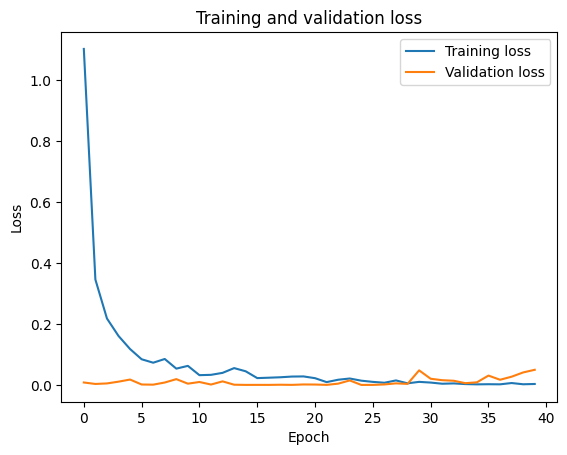

In [10]:
num_epochs = 100
best_train_loss = float('inf')
best_val_loss = float('inf')
patience, trigger = 15, 0  # Early stopping parameters
best_model_state = None

train_losses = []
val_losses = []

pbar = tqdm(range(num_epochs), desc="Training")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.cuda()
        # labels in {0,1}, convert to float for BCEWithLogitsLoss
        labels = labels.float().cuda().view(-1, 1)
        optimizer.zero_grad()
        
        # Optionally, mixup can be applied here
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    scheduler.step()
    avg_train_loss = running_loss / len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            # labels in {0,1}, convert to float for BCEWithLogitsLoss
            labels = labels.float().cuda().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    avg_val_loss = val_loss / len(val_dataset)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    pbar.set_description(f"Epoch {epoch+1}/{num_epochs}: train loss: {avg_train_loss:.8f}, val loss: {avg_val_loss:.8f} (best: {best_val_loss:.8f})")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_train_loss = avg_train_loss
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        trigger = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger += 1
        if trigger >= patience:
            print('Early stopping triggered')
            break

# Load the best model state
model.load_state_dict(best_model_state)

# Print the losses
print(f"Training loss: {best_train_loss:.4f}, Validation loss: {best_val_loss:.4f}")

# Plot the training and validation loss
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate the model for the following metrics: accuracy, precision, recall, and F1 score.

# Put model in evaluation mode
model.eval()

# Collect predictions and ground truth labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        output = torch.sigmoid(outputs)
        preds = (outputs.squeeze() > 0.3).cpu().numpy()  # Convert logits to binary predictions
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Validation Accuracy: 0.9921
Validation Precision: 0.9878
Validation Recall: 1.0000
Validation F1 Score: 0.9939


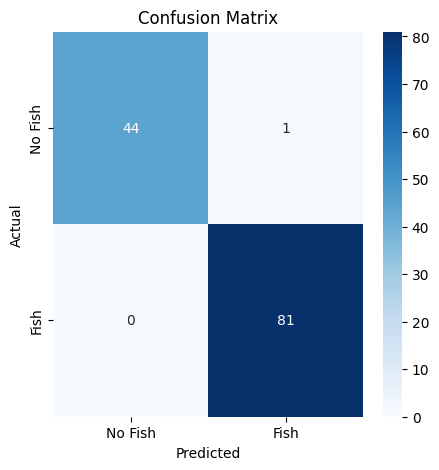

In [12]:
# Also, let's plot the confusion matrix of the predictions.

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fish", "Fish"], yticklabels=["No Fish", "Fish"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

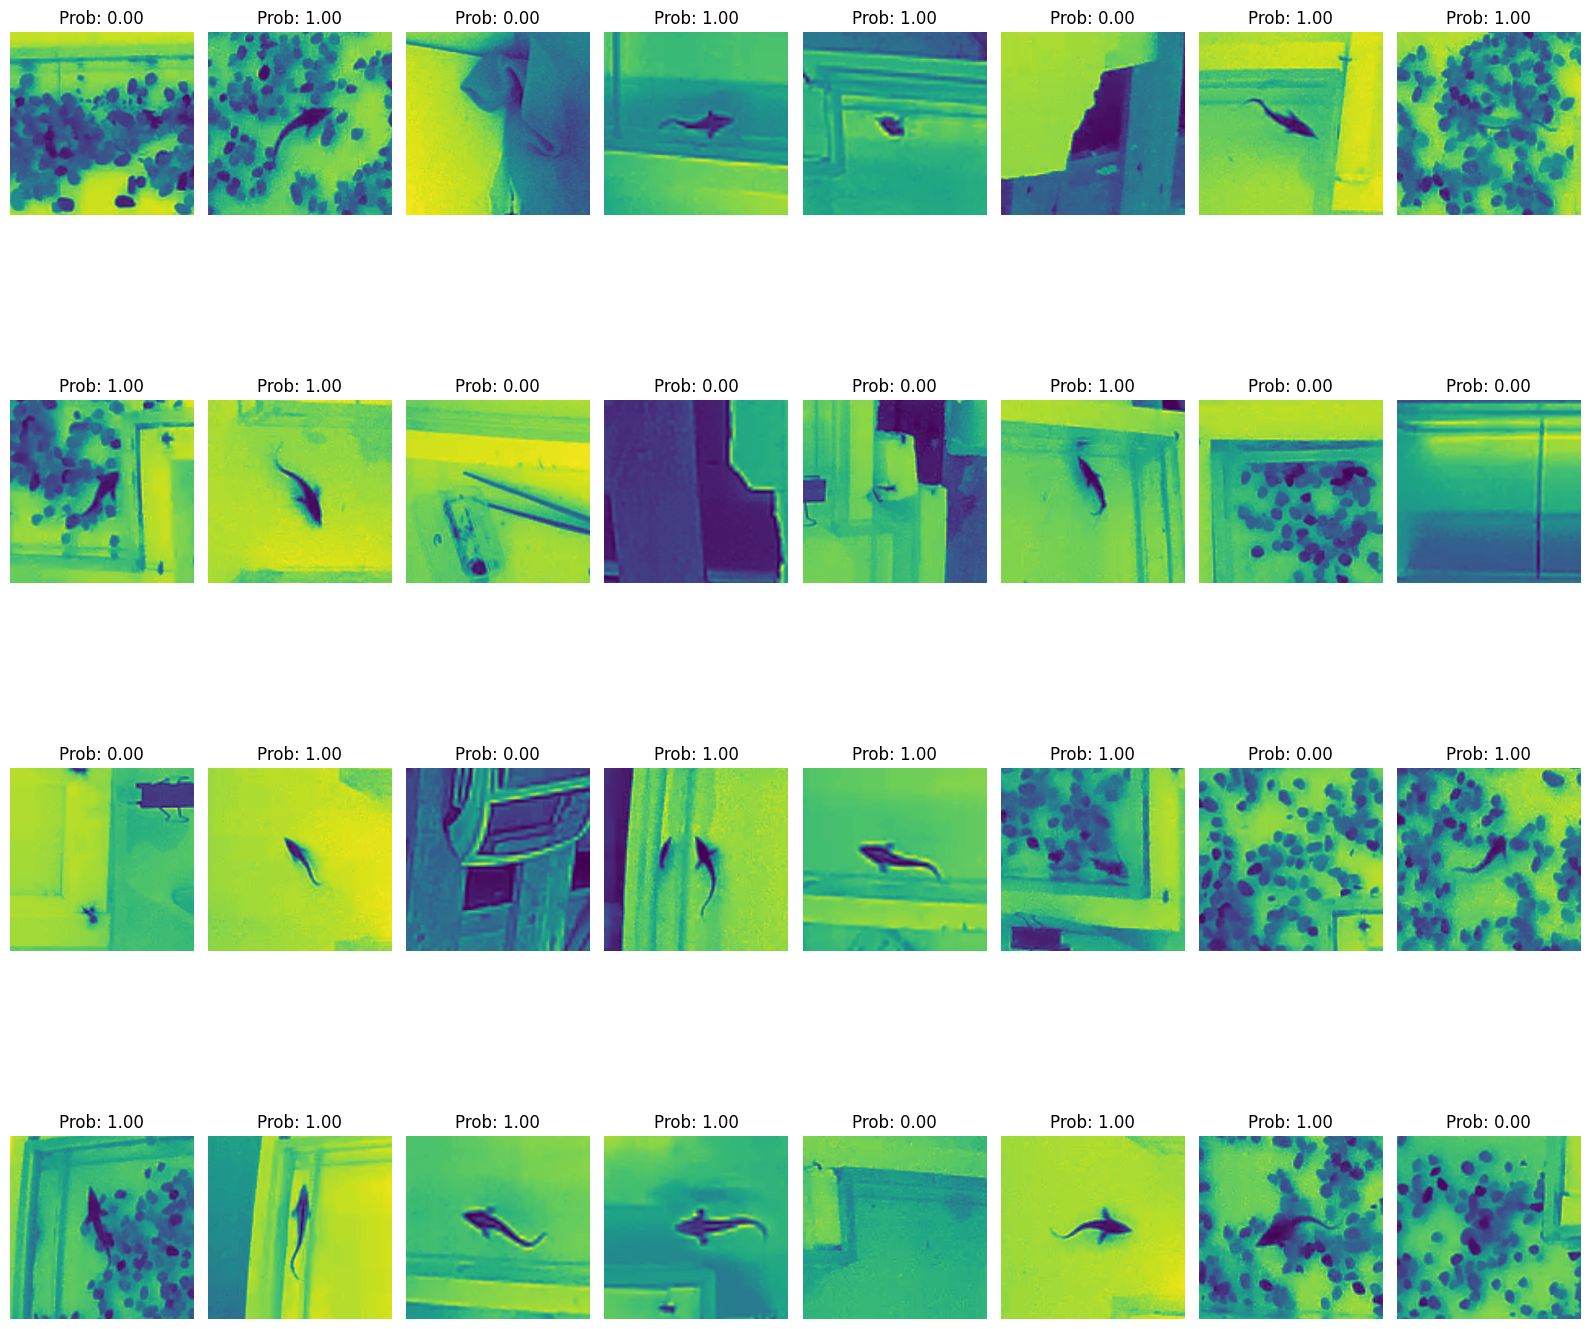

In [13]:
# Finally, let's display a grid of validation data using matplotlib for human inspection of the performance of the model.
images, labels = next(iter(val_loader))

# shuffle images and labels
idx = torch.randperm(images.shape[0])
images = images[idx]
images = images[idx]

num_samples = 32
# take only 32 images
images = images[:num_samples].to(device)
labels = labels[:num_samples].to(device)

outputs = torch.sigmoid(model(images))
outputs = outputs.squeeze(1).detach().cpu().numpy()  # Convert tensor to numpy array
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16,16))

for idx, image in enumerate(images):
    # renormalize the image to [0-1]
    image = image / 2 + 0.5

    # convert to image to grayscale and to numpy
    image = image.mean(dim=0).cpu().numpy()

    ax = axes.flatten()[idx]
    ax.imshow(image)
    #ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Prob: {outputs[idx]:.2f}")
    ax.set_axis_off()
plt.tight_layout()
plt.show()


In [14]:
# write the model to a file
torch.save(model.state_dict(), '../data/models/model_efficient_b0_v1.pth')